In [1]:
suppressMessages(library(tidyverse)) #loading libraries, suppresses warning messages.
suppressMessages(library(tidymodels)) 
suppressMessages(library(repr))
suppressMessages(library(GGally))

set.seed(4747) #setting seed for reproducibility's sake. 47 is hexadecimal for g, and our group number "g47"

## Project Proposal

**Introduction**

Tennis is a sport using a racket and a rubber ball. It can be played with either one or two players on each team. The objective of the game is to pass the ball over the net in such a way so that the opponent is unable to return the ball. The player with the most points wins. Each player has a rank corresponding to the number of wins. In each yearly tennis season, players compete with each other to accumulate wins.

In our data analysis, we aim to answer the following question: “What relationship does a player’s age and number of seasons played have on a player’s current ranking?” To answer this, we will arrange the “Current Rank” column to store a range of rank each player rank lies in (Rank 1-50, Rank 51-100, etc). This will be our category for classification.

We will be using the “Player Stats for Top 500 Players” dataset which includes statistical  information about the top 500 tennis players in the world. Specifically, we will focus on the following variables: “Age, Current Rank, and Seasons”

In [2]:
url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
dir.create("data")
download.file(url, "data/top500players.csv") # creates directory "data" and downloads the data used into the folder

### RUN THIS BLOCK ONLY ONCE 

In [3]:
player_data <- read_csv("data/top500players.csv", show_col_types = FALSE)
glimpse(player_data)

New names:
* `` -> ...1



Rows: 500
Columns: 38
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1~
$ Age                <chr> "26 (25-04-1993)", "18 (22-12-2001)", "32 (03-11-19~
$ Country            <chr> "Brazil", "United Kingdom", "Slovakia", "Korea, Rep~
$ Plays              <chr> "Right-handed", "Left-handed", "Right-handed", "Rig~
$ Wikipedia          <chr> "Wikipedia", "Wikipedia", "Wikipedia", "Wikipedia",~
$ `Current Rank`     <chr> "378 (97)", "326 (119)", "178 (280)", "236 (199)", ~
$ `Best Rank`        <chr> "363 (04-11-2019)", "316 (14-10-2019)", "44 (14-01-~
$ Name               <chr> "Oscar Jose Gutierrez", "Jack Draper", "Lukas Lacko~
$ Backhand           <chr> NA, "Two-handed", "Two-handed", "Two-handed", "Two-~
$ `Prize Money`      <chr> NA, "$59,040", "US$3,261,567", "$374,093", "US$6,09~
$ Height             <chr> NA, NA, "185 cm", NA, "193 cm", NA, NA, NA, NA, NA,~
$ `Favorite Surface` <chr> NA, NA, "Fast (H, G) 40%", NA, "Fast (H, G) 36%", "~
$ `Turned Pro`    

In [4]:
colnames(player_data) <- make.names(colnames(player_data))

player_data_tidy <- player_data |>
                        separate(Best.Elo.Rank, c("Best.Rank", NA), sep = " ") |> #Removes the date next to the all-time best ranks
                        separate(Current.Elo.Rank, c("Current.Rank", NA), sep = " ") |> #Removes the elo next to the ranks
                        separate(Age, c("Age", NA), sep = " ") |>
                            select(Name, Age, Prize.Money, Seasons, Current.Rank, Best.Rank) |>
                         mutate(Prize.Money = gsub("[a-zA-Z$, -]", "", Prize.Money)) |> #removes all string chars next to numbers, US$ etc.
                         mutate(Prize.Money = as.numeric(Prize.Money)) |>
                         mutate(Best.Rank = as.numeric(Best.Rank)) |>
                         mutate(Current.Rank = as.numeric(Current.Rank)) |>
                         mutate(Age = as.numeric(Age)) |>
                        na.omit()

head(player_data_tidy)

Name,Age,Prize.Money,Seasons,Current.Rank,Best.Rank
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lukas Lacko,32,3261567,14,144,60
Bernard Tomic,27,6091971,11,100,21
Hubert Hurkacz,22,1517157,5,33,33
Sanjar Fayziev,25,122734,5,189,187
Felix Auger Aliassime,19,1893476,3,51,30
Daniil Medvedev,23,10507693,5,5,4


In [5]:
nNA <- 500 - nrow(player_data_tidy)
paste("Number of NAs:", nNA, sep = " ")

[1] "Number of NAs: 317"

In [6]:
# cuts Current.Rank and Best.Rank into different intervals with step 20 and adds them to a vector.
## "labels" arg names each interval.
Current_Rank_factor <- player_data_tidy$Current.Rank |>
                            cut(c(0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200), 
                                labels = c("1-20", "21-40", "41-60", "61-80", "81-100",
                                           "101-120", "121-140", "141-160", "161-180", "181-200")) 

Best_Rank_factor <- player_data_tidy$Best.Rank |>
                            cut(c(0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200), 
                                labels = c("1-20", "21-40", "41-60", "61-80", "81-100",
                                           "101-120", "121-140", "141-160", "161-180", "181-200")) 

player_data_factor <- mutate(player_data_tidy, Rank.Range = Current_Rank_factor) |>
                      mutate(Best.Rank.Range = Best_Rank_factor) #vectors are added to df

head(player_data_factor)

Name,Age,Prize.Money,Seasons,Current.Rank,Best.Rank,Rank.Range,Best.Rank.Range
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Lukas Lacko,32,3261567,14,144,60,141-160,41-60
Bernard Tomic,27,6091971,11,100,21,81-100,21-40
Hubert Hurkacz,22,1517157,5,33,33,21-40,21-40
Sanjar Fayziev,25,122734,5,189,187,181-200,181-200
Felix Auger Aliassime,19,1893476,3,51,30,41-60,21-40
Daniil Medvedev,23,10507693,5,5,4,1-20,1-20


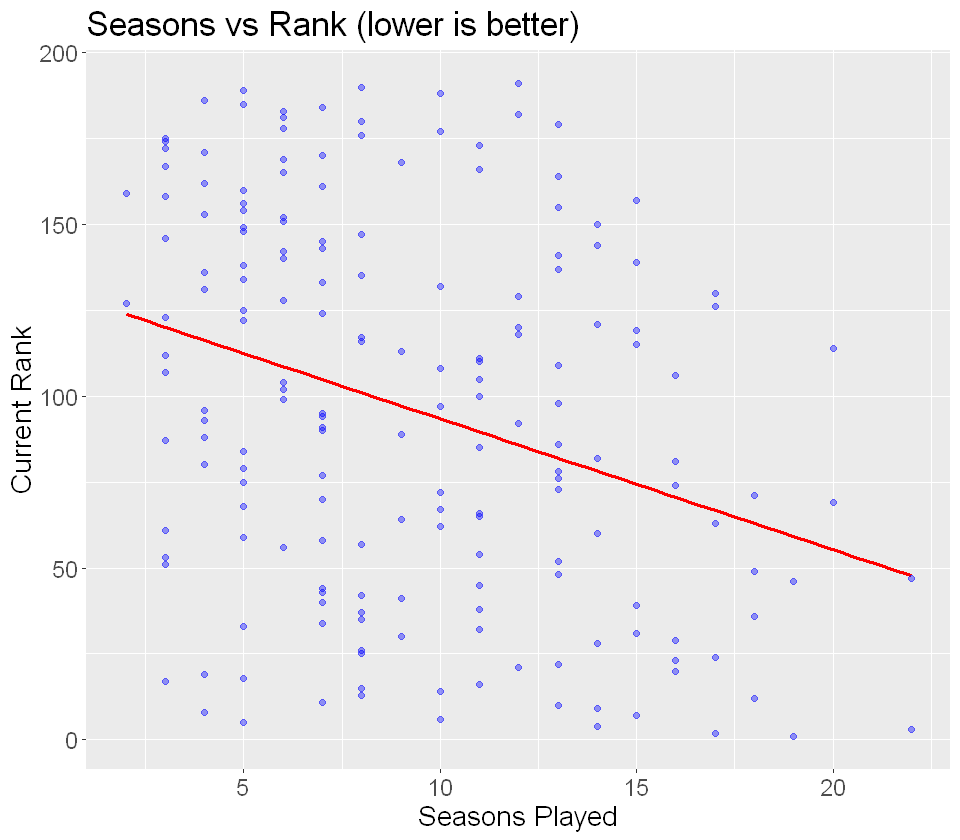

In [7]:
options(repr.plot.length = 10, repr.plot.width = 8)

SeasonsVsRank <- ggplot(player_data_tidy, aes(x = Seasons, y = Current.Rank)) + 
                    geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(colour = "blue", alpha = 0.4) +
                     labs(x = "Seasons Played", y = "Current Rank", title = "Seasons vs Rank (lower is better)") + 
                     theme(text = element_text(size = 17)) #legend could be added


AgeVsSeasons <- ggplot(player_data_tidy, aes(x = Age, y = Seasons)) + 
                    geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Age", y = "Seasons Played", title = "Age vs Seasons") + 
                     theme(text = element_text(size = 17)) #legend could be added


SeasonsVsRank

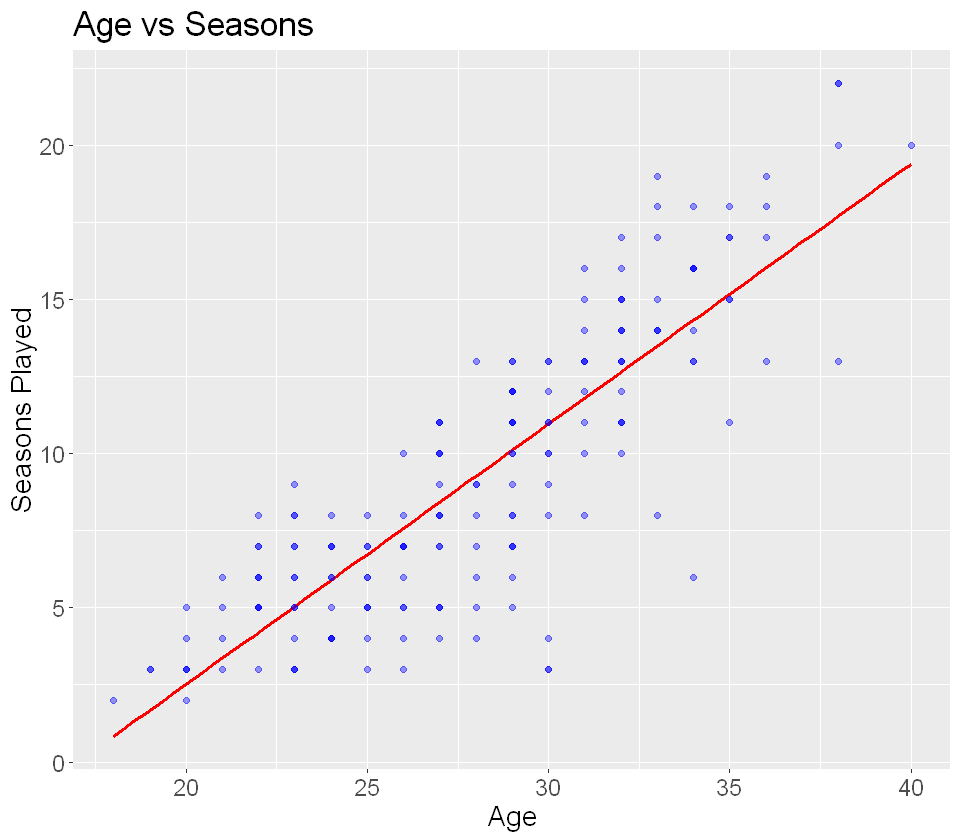

In [8]:
AgeVsSeasons

We can see the distribution of Age with seasons played has a linear trend in the scatterplot. We will use rank as a category and classify the rank using the relationship with age and seasons played.

**Methods**

We will conduct our data analysis using classification by creating a scatter plot between number of seasons played and age, and we will classify based on Current Rank. As rank is not a factor, we modify it as a range of 50s. These 2 variables are the most potentially useful for predicting athlete rank. Rank indicates historical grade of athletes. Number of seasons indicates experience and therefore may correspond to a higher rank because tennis involves decision-making.

We will visualize our data using scatter plot and histogram. A scatter plot shows the linear relationships between Age, Seasons, and Current Rank. It can be used to predict the rank of athletes by using several explanatory variables. A histogram can show the distribution of the sample, and we can see key statistical summary such as sample mean and sample median from histogram. We can also see whether the distribution is normal.

**Expected Outcomes & Significance**

- We expect to find the relationship between Age, Seasons, and Rank. We predict that athletes who are older and have played more seasons to have higher ranks because they are more experienced.

- These findings could help the Sport industry select potential athletes and predict their success. Sport universities could use Seasons Played and Age to determine which athletes they would like to admit in competitions.

- Using only seasons and age as predictors for athlete rank is not very accurate because ranks can be influenced by many other factors which are not present in this dataset. For example, weather on the game day, psychological quality of athletes, brands of shoes and sportswear could be potential factors for athlete grades. The physical trait also matters to a great extent of their performance and rank. Future questions could focus on addressing these problems by exploring other variables that have relationships with rank. 